In [28]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 
 
transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])
training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Data augmentation is only done on training images
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
 
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True) # Batch size of 100 i.e to work with 100 images at a time
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() # This process will happen in normal cpu.
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [32]:
# Different classes in CIPHAR 10 dataset. 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

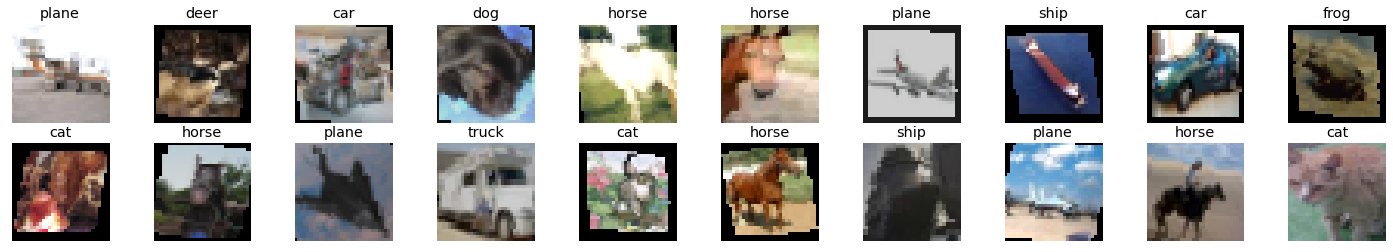

In [33]:
# We iter the batch of images to display
dataiter = iter(training_loader) # converting our train_dataloader to iterable so that we can iter through it. 
images, labels = dataiter.next() #going from 1st batch of 100 images to the next batch
fig = plt.figure(figsize=(25, 4)) 

# We plot 20 images from our train_dataset
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) 
  plt.imshow(im_convert(images[idx])) #converting to numpy array as plt needs it.
  ax.set_title(classes[labels[idx].item()])

In [34]:
Model 
class Net(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) # input is color image, hence 3 i/p channels. 16 filters, kernal size is tuned to 3 to avoid overfitting, stride is 1 , padding is 1 extract all edge features.
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1) # We double the feature maps for every conv layer as in pratice it is really good.
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500) # I/p image size is 32*32, after 3 MaxPooling layers it reduces to 4*4 and 64 because our last conv layer has 64 outputs. Output nodes is 500
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10) # output nodes are 10 because our dataset have 10 different categories
    def forward(self, x):
      x = F.relu(self.conv1(x)) #Apply relu to each output of conv layer.
      x = F.max_pool2d(x, 2, 2) # Max pooling layer with kernal of 2 and stride of 2
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64) # flatten our images to 1D to input it to the fully connected layers
      x = F.relu(self.fc1(x))
      x = self.dropout1(x) # Applying dropout b/t layers which exchange highest parameters. This is a good practice
      x = self.fc2(x)
      return x

In [35]:
model = Net().to(device) # run our model on cuda GPU for faster results
model

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [36]:
criterion = nn.CrossEntropyLoss() # same as categorical_crossentropy loss used in Keras models which runs on Tensorflow
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # fine tuned the lr

In [37]:
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader:
    inputs = inputs.to(device) # input to device as our model is running in mentioned device.
    labels = labels.to(device)
    outputs = model(inputs) # every batch of 100 images are put as an input.
    loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels. 
    
    optimizer.zero_grad() #setting the initial gradient to 0
    loss.backward() # backpropagating the loss
    optimizer.step() # updating the weights and bias values for every single step.
    
    _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

  else:
    with torch.no_grad(): # we do not need gradient for validation.
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
      
    epoch_loss = running_loss/len(training_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(training_loader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying 
    running_corrects_history.append(epoch_acc)

    print("Model's state_dict:")
    for param_tensor in model.state_dict():
      print(param_tensor, "\t", model.state_dict()[param_tensor].size())

     

   
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

Model's state_dict:
conv1.weight 	 torch.Size([16, 3, 3, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([500, 1024])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
epoch : 1
training loss: 1.7248, acc 36.8260 
validation loss: 1.4012, validation acc 49.1000 
Model's state_dict:
conv1.weight 	 torch.Size([16, 3, 3, 3])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 3, 3])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 3, 3])
conv3.bias 	 torch.Size([64])
fc1.weight 	 torch.Size([500, 1024])
fc1.bias 	 torch.Size([500])
fc2.weight 	 torch.Size([10, 500])
fc2.bias 	 torch.Size([10])
epoch : 2
training loss: 1.3982, acc 49.5500 
validation loss: 1.2627, validation acc 54.9600 
Model's state_dict:
conv1.weight 	 torch.Size([16, 3, 3, 3])
conv1.bias 	 torch.Si

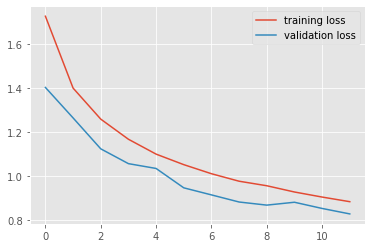

In [38]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

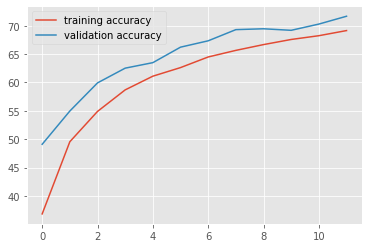

In [39]:
plt.style.use('ggplot')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()

In [40]:
import PIL.ImageOps

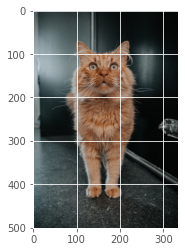

In [41]:
import requests
from PIL import Image

url = 'https://images.unsplash.com/photo-1568198532231-afb7b87ebd66?ixlib=rb-1.2.1&auto=format&fit=crop&w=334&q=80'
#'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcT76mSMtKQWGstcqGi-0kPWJyVBqz8RCp8SuplMipkidRY0z9Mc&usqp=CAU'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

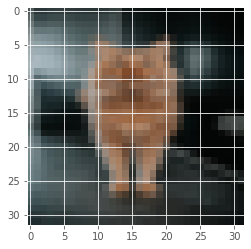

In [42]:
img = transform(img)  # applying the transformations on new image as our model has been trained on these transformations
plt.imshow(im_convert(img)) # convert to numpy array for plt

In [43]:
image = img.to(device).unsqueeze(0) # put inputs in device as our model is running there
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

cat


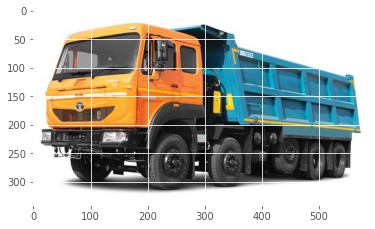

In [44]:
import requests
from PIL import Image

url = 'https://www.tatamotors.com/wp-content/uploads/2018/01/19065145/mhcv-construck.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

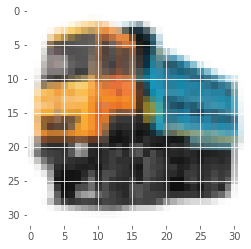

In [45]:
img = transform(img)  # applying the transformations on new image as our model has been trained on these transformations
plt.imshow(im_convert(img)) # convert to numpy array for plt

In [46]:
image = img.to(device).unsqueeze(0) # put inputs in device as our model is running there
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

truck


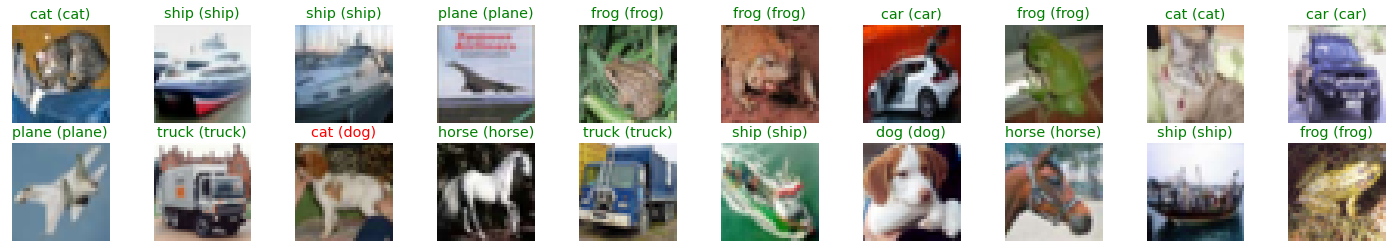

In [47]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

